In [1]:
import sys
import os
os.environ['BACKEND'] = 'numpy'


import numpy as np
import pandas as pd 
import numba
from numba import njit, prange
from typing import List, Tuple, Sequence, Dict, Any, Union
import time

# Add the parent directory (project root) to sys.path
script_dir                  = os.path.dirname(os.curdir)
parent_dir                  = os.path.abspath(os.path.join(script_dir, '..', '..'))
parent_parent_dir           = os.path.abspath(os.path.join(parent_dir, '..'))
parent_parent_parent_dir    = os.path.abspath(os.path.join(parent_parent_dir, '..'))

for path in [parent_dir, parent_parent_dir, parent_parent_parent_dir]:
    if path not in sys.path:
        sys.path.append(path)

# ------------------------------------------------------------------
#! General
from QES.general_python.common.timer import Timer, timeit
from QES.general_python.common.binary import get_global_logger, Array
from QES.general_python.common import Plotter, colorsCycle, linestylesCycle
from QES.general_python.common import Directories
from QES.general_python.maths.math_utils import Fitter, FitterParams
from QES.general_python.maths.statistics import Fraction
# ------------------------------------------------------------------
# from QES.general_python.common.hdf5_lib import HDF5Handler, read_hdf5_extract_and_concat_list
from QES.general_python.common.hdf5man import HDF5Manager
from QES.general_python.physics import entropy, density_matrix

# ------------------------------------------------------------------
from QES.Algebra.Model.Interacting.Spin.ultrametric import UltrametricModel
from QES.Algebra.hilbert import HilbertSpace

# ------------------------------------------------------------------
from QES.Algebra.Properties import time_evo
from QES.Algebra.Properties import statistical
from QES.general_python.algebra.linalg import act, overlap, overlap_diag

# ------------------------------------------------------------------
import QES.Algebra.Operator.operators_spin as op_spin

logger      = get_global_logger()

# ------------------------------------------------------------------
data_dir = Directories(os.curdir, '../../2025_um_evolotion/data_add')
data_dir = Directories(os.curdir, '../../2025_um_evolotion/data_big_times')
# data_dir.mkdir()

#! OLD
from QES.general_python.physics.__operators__ import Operators

directory_lips_random_models    = Directories(r"/media/klimak/ObiOne/FADING_RAN_MODELS/FINAL/DATA/ETH_MAT_TIME_EVO")
directory_lips_random_models2   = Directories(r"/media/klimak/ObiOne/FADING_RAN_MODELS/FINAL/DATA/ETH_MAT_TIME_EVO/ETH_MAT_TIME_EVO")
directory_bem2_random_models    = Directories(r"/media/klimak/ObiOne/ObiTwoBackup/BEM_2_NEW/DATA/ETH_MAT_TIME_EVO")
directory_bem2_random_models2   = Directories(r"/media/klimak/ObiOne/ObiTwoBackup/BEM_2_NEW/DATA/ETH_MAT_TIME_EVO/ETH_MAT_TIME_EVO")
directory_bem2_uniform_models   = Directories(r"/media/klimak/ObiOne/FADING_RAN_MODELS/FINAL/UNIFORM/ETH_MAT_TIME_EVO_UNIFORM")

08_07_2025_18-09_30 [INFO] Log file created: ./log/QES_08_07_2025_18-09_30.log
08_07_2025_18-09_30 [INFO] Log level set to: info
08_07_2025_18-09_30 [INFO] ############Global logger initialized.############
08_07_2025_18-09_30 [INFO] JAX is not available. Using NumPy as the active backend.
08_07_2025_18-09_30 [INFO] **************************************************
08_07_2025_18-09_30 [INFO] Backend Configuration:
08_07_2025_18-09_30 [INFO] 		NumPy Version: 1.26.4
08_07_2025_18-09_30 [INFO] 		SciPy Version: 1.13.1
08_07_2025_18-09_30 [INFO] 		JAX Version: Not Available
08_07_2025_18-09_30 [INFO] 		Active Backend: numpy
08_07_2025_18-09_30 [INFO] 			JAX Available: False
08_07_2025_18-09_30 [INFO] 			Default Seed: 42
08_07_2025_18-09_30 [INFO] 		NumPy Backend Details:
08_07_2025_18-09_30 [INFO] 				Main Module: numpy
08_07_2025_18-09_30 [INFO] 				Random Module: Generator
08_07_2025_18-09_30 [INFO] 				SciPy Module: scipy
08_07_2025_18-09_30 [INFO] 		Active Data Types:
08_07_2025_18-09_

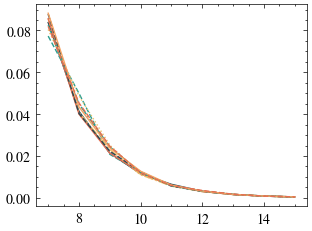

In [24]:
rng                 = np.random.default_rng()
rand_num            = rng.integers(0, int(1e5))

bw_df               = pd.read_csv("model/bw.csv", index_col=0, header=None, dtype=float)
mls_df              = pd.read_csv("model/mls.csv", index_col=0, header=None, dtype=float)
bw_df.index         = [f'{x:.2f}' for x in bw_df.index]
mls_df.index        = [f'{x:.2f}' for x in mls_df.index]
bw_df.columns       = list(range(7, 17))
mls_df.columns      = list(range(7, 16))

for i in range(len(bw_df.columns)):
    mls_df.iloc[i].plot(label=f'{bw_df.index[i]}', linestyle=next(linestylesCycle))


In [25]:

def align_and_stack(xs         : Sequence[np.ndarray],
                    ys         : Sequence[np.ndarray],
                    fill_value : float      = np.nan,
                    shared_x   : np.ndarray = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Align multiple (x, y) samples onto their union x-axis and stack
    the y-arrays, filling gaps with fill_value.

    Parameters
    ----------
    xs
        Sequence of 1D arrays of x-coordinates.
    ys
        Sequence of 1D arrays of y-values; must have same length as xs.
    fill_value
        Scalar to use where a sample has no y at a given union-x.

    Returns
    -------
    x_union : np.ndarray, shape (F,)
        Sorted unique union of all x-values.
    Y       : np.ndarray, shape (N, F)
        Stacked y-values for N samples, aligned to x_union.
    """
    if shared_x is None:
        if len(xs) != len(ys):
            raise ValueError("`xs` and `ys` must have the same number of samples")
    else:
        logger.info("Using shared x-axis, it gives us indices in samples in y for a given x", lvl=1)
        logger.info(f"Shared x-axis: {shared_x}", lvl=2)
        
    # compute sorted union of all x
    x_union     = np.unique(np.concatenate(xs))
    print(f"Union x-axis: {x_union}")
    n_samples   = len(ys)
    n_columns   = x_union.size

    # allocate output array
    Y           = np.full((n_samples, n_columns), fill_value, dtype=ys[0].dtype if hasattr(ys[0], 'dtype') else float)
    print(f"Y shape: {Y.shape}")

    # fill each row by searching where its x_i lands in x_union
    idx_in_x    = 0
    for i in range(n_samples):
        print(f"\tSample {i}")
        if shared_x is not None:
            # move to the next sample in y
            if i >= shared_x[idx_in_x]:
                idx_in_x    +=   1
            print(f"\t\tidx_in_x: {idx_in_x}")
            x_i = xs[idx_in_x]
            y_i = ys[i]
        else:
            x_i = xs[i]
            y_i = ys[i]            
            
        idx         = np.searchsorted(x_union, x_i)
        Y[i, idx]   = y_i

    return x_union, Y

x1 = [0, 1, 2, 3, 4]
y1 = [1] * 5
y12= [5] * 5
x2 = [1, 2, 3, 4, 5, 6]
y2 = [2] * 6
y3 = [3] * 6

# align_and_stack(
#     [x1, x2],
#     [y1, y12, y2, y3],
#     fill_value=np.nan,
#     shared_x=[2, 4]
# )

# def sum_previous()


#### Time evolution readout

```python
    data_out = {
        'evolution'     : (data_evo_time, data_evo_av, data_evo_av_rm, data_evo_d_av),
        'distribution'  : ((distr_bins, distr), (distr_bins_rm, distr_rm)),
        'moments'       : ((mu, mu2, mu3, mu4), (mu_rm, mu2_rm, mu3_rm, mu4_rm)),
        'fft'           : (data_evo_fft_om, data_evo_fft, data_evo_fft_n)
    }
```
    

In [26]:
def read_time_evolution_uniform(
            directories     : List[Directories],
            alpha           : float,
            ns              : int,
            n               : int,
            operator        : str,
            window          : int = 31,
        ):
    
    #! keys for Python data
    time_key        = '/time'
    time_evo_key    = f'/time_evolution/{operator}/expectation'
    time_evo_d_key  = f'/time_evolution/{operator}/diag_ens'
    model           = UltrametricModel(ns = ns, n = n, alphas = alpha)
    modelstr        = str(model)
    directories     = [Directories(d, modelstr) for d in directories]
    filelist        = [x for d in directories for x in d.list_files(filters = [lambda x: str(x).endswith('h5')])]
    filelist_time   = [str(x) for x in filelist if "evo_" in str(x)]

    #! read data from the Python files
    if len(filelist_time):
        data_evo_time           = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_time, dataset_keys=[time_key])
        data_evo_time           = [x[time_key] for x in data_evo_time][0] # same time for all files
        logger.info(f"data_evo_time shape: {data_evo_time.shape}", lvl=2, color='blue')
        
        data_evo_all            = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_time, dataset_keys=[time_evo_key])
        data_evo_all            = [x[time_evo_key] for x in data_evo_all]
        data_evo_samples        = [len(x) for x in data_evo_all]
        logger.info(f"data_evo_samples: {data_evo_samples} for {modelstr}", lvl=3, color='blue')

        data_evo_all            = [y for x in data_evo_all for y in x if y.shape[0] > 0]
        data_evo_all            = np.array(data_evo_all, dtype=float)
        logger.info(f"reshaped to: {data_evo_all.shape}", lvl=4, color='blue')
        # data_evo_av             = data_evo_av.reshape(-1, data_evo_av.shape[-1], order='C')
        
        #! diagonal ensemble
        data_evo_d_av           = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_time, dataset_keys=[time_evo_d_key])
        data_evo_d_av           = [x[time_evo_d_key] for x in data_evo_d_av]
        data_evo_d_av           = [y for x in data_evo_d_av for y in x]
        data_evo_d_av           = np.array(data_evo_d_av, dtype=float)
        # data_evo_d_av           = np.array([x[time_evo_d_key] for x in data_evo_d_av]).flatten()

        #! remove diagonal ensemble
        data_evo_av             = data_evo_all - data_evo_d_av[:, np.newaxis]

        #! remove structure
        data_evo_av_rm          = statistical.spectral_structure(data_evo_av, window = window)
        
    else:
        return None
    
    #! create the distribution of the data
    distr, distr_bins       = np.histogram(data_evo_av, bins=100, density=True)
    distr_bins              = 0.5 * (distr_bins[1:] + distr_bins[:-1])
    
    distr_rm, distr_bins_rm = np.histogram(data_evo_av_rm, bins=100, density=True)
    distr_bins_rm           = 0.5 * (distr_bins_rm[1:] + distr_bins_rm[:-1])
    
    #! moments of the values
    mu, mu2, mu3, mu4       = np.mean(data_evo_av, axis = 1),   \
                            np.mean(data_evo_av**2, axis = 1),  \
                            np.mean(data_evo_av**3, axis = 1),  \
                            np.mean(data_evo_av**4, axis = 1)
    
    mu_rm, mu2_rm, mu3_rm, mu4_rm = np.mean(data_evo_av_rm, axis = 1),   \
                            np.mean(data_evo_av_rm**2, axis = 1),  \
                            np.mean(data_evo_av_rm**3, axis = 1),  \
                            np.mean(data_evo_av_rm**4, axis = 1)
    
    #! FFT
    time_delta              = data_evo_time[1] - data_evo_time[0]
    time_num                = data_evo_time.shape[-1]
    time_norm               = 2 / np.sqrt(time_num)
    data_evo_fft_om         = np.fft.fftfreq(time_num, d=time_delta)[1:time_num//2] * 2 * np.pi
    data_evo_fft_base       = np.fft.fft(data_evo_av, axis=1)[:, 1:time_num//2] * time_norm
    data_evo_fft            = np.abs(data_evo_fft_base)**2 / data_evo_time.shape[0]**2
    data_evo_fft            = np.mean(data_evo_fft, axis = 0)
    data_evo_fft_n          = np.trapz(data_evo_fft, x=data_evo_fft_om, axis=0)
    data_evo_fft            = data_evo_fft / data_evo_fft_n
    
    logger.info(f"time delta: {time_delta}, time num: {time_num}, shape: {data_evo_fft_om.shape}", lvl = 2)
    logger.info(f"data_evo_fft shape: {data_evo_fft.shape}", lvl = 3, color = 'blue')
    
    data_out = {
        'evolution'     : (data_evo_time, data_evo_av, data_evo_av_rm, data_evo_d_av),
        'distribution'  : ((distr_bins, distr), (distr_bins_rm, distr_rm)),
        'moments'       : ((mu, mu2, mu3, mu4), (mu_rm, mu2_rm, mu3_rm, mu4_rm)),
        'fft'           : (data_evo_fft_om, data_evo_fft, data_evo_fft_n)
    }
    
    return data_out

#### Read the energy of the system
```python
data_out = {
    'energy'                    : (data_energy, mean_lvl_spacing, bandwidth_data),
    'ldos'                      : data_ldos,
    'iprs'                      : iprs,
    'participation_entropies'   : participation_entropies,
}
```

In [40]:
def read_energy(
            directories     : List[Directories],
            alpha           : float,
            ns              : int,
            n               : int,
        ):
    
    #! keys for Python data
    energy_key      = '/energies'
    ldos_key        = '/ldos'
    model           = UltrametricModel(ns = ns, n = n, alphas = alpha)
    modelstr        = str(model)
    directories     = [Directories(d, modelstr) for d in directories]
    filelist        = [x for d in directories for x in d.list_files(filters = [lambda x: str(x).endswith('h5')])]
    filelist_energy = [str(x) for x in filelist if "stat_" in str(x) or "energy_" in str(x)]

    #! read data from the Python files
    if len(filelist_energy):
        data_energy             = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_energy, dataset_keys=[energy_key])
        data_energy             = [x[energy_key] for x in data_energy]
        data_energy             = [y for x in data_energy for y in x if y.shape[0] > 0] # flatten and remove empty arrays
        data_energy             = np.array(data_energy, dtype=float)
        # data_energy             = data_energy.reshape(-1, data_energy.shape[-1], order='C')
        differences             = np.diff(data_energy, axis=1)
        bandwidth_data          = np.mean(np.var(data_energy, axis=1), axis=0)
        mean_lvl_spacing        = np.mean(np.mean(differences, axis = 1), axis=0)
        
        # gap ratio
        mean_energies           = np.mean(data_energy, axis=1)
        indices_mean            = np.argmin(np.abs(data_energy - mean_energies[:, np.newaxis]), axis=1)
        differences_mid         = Fraction.take_fraction(500, differences.T, around_idx=int(np.mean(indices_mean)))
        gap_ratio               = np.mean(np.mean(np.minimum(differences_mid[:-1], differences_mid[1:]) / np.maximum(differences_mid[:-1], differences_mid[1:]), axis = 1))

        #! LDOS
        data_ldos               = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_energy, dataset_keys=[ldos_key])
        data_ldos               = [x[ldos_key] for x in data_ldos]
        data_ldos               = [y for x in data_ldos for y in x if y.shape[0] > 0]
        data_ldos               = np.array(data_ldos, dtype=float)
        # data_ldos               = data_ldos.reshape(-1, data_ldos.shape[-1], order='C')

        #! IPRS from the LDOS
        qs                      = [0.5, 1.0, 2.0, 3.0, 4.0] # divide by 2, as we have the LDOS, which is already squared
        iprs                    = { q: statistical.inverse_participation_ratio(data_ldos.T, q = q / 2) for q in qs }
        participation_entropies = { q: entropy.participation_entropy(data_ldos.T, q = q / 2) for q in qs }
        
        #! Reduced density matrix - damn, we have abs**2...
        # subsystems              = ((2, 2**(ns-1)), (2**(ns // 2), 2**(ns // 2)))
        # for (dimA, dimB) in subsystems:
        #     rho                 = [density_matrix.rho_numba(ov, dimA=dimA, dimB=2**(ns - 1)) for ov in overlaps]
        #     #! calculate the entropies for the initial state in the eigenbasis
        #     schmidt_val, _      = density_matrix.schmidt_numba(rho, 2, 2**(ns - 1), eig = False)
    else:
        return None
    
    data_out = {
        'energy'                    : (data_energy, mean_lvl_spacing, bandwidth_data, gap_ratio),
        'ldos'                      : data_ldos,
        'iprs'                      : iprs,
        'participation_entropies'   : participation_entropies,
    }

    return data_out

#### Read the spectral functions
```python
data_out                = {
    'histogram' : ((data_hist_bins, data_hist_av), (data_hist_typ, data_hist_count)),
    'cdf'       : (oms, smooth, cdf, g),
    'cdf_typ'   : (omst, smootht, cdft, gt)
}
```

In [28]:
def read_histogram(
            directories     : List[Directories],
            alpha           : float,
            ns              : int,
            n               : int,
            operator        : str,
            window          : int = 31,
        ):
    
    #! keys for Python data
    hist_key        = f'/historgram/{operator}/average/values'
    hist_typ_key    = f'/historgram/{operator}/typical/values'
    hist_count_key  = '/historgram/counts'
    hist_edges_key  = '/historgram/edges'
    model           = UltrametricModel(ns = ns, n = n, alphas = alpha)
    modelstr        = str(model)
    directories     = [Directories(d, modelstr) for d in directories]
    filelist        = [x for d in directories for x in d.list_files(filters = [lambda x: str(x).endswith('h5')])]
    filelist_hist   = [str(x) for x in filelist if "hist_" in str(x)]
    
    if len(filelist_hist):
        data_hist_bins          = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_hist, dataset_keys=[hist_edges_key])
        data_hist_bins          = np.mean([x[hist_edges_key] for x in data_hist_bins], axis=0) #! bins should be the same for all files

        #! read the histogram data
        
        # average
        data_hist_av            = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_hist, dataset_keys=[hist_key])
        data_hist_av            = np.mean([x[hist_key] for x in data_hist_av], axis=0)
        mask                    = (data_hist_av > 1e-10) & np.isfinite(data_hist_av)
        if mask.any():
            data_hist_av         = data_hist_av[mask] # remove zeros
            data_hist_bins       = data_hist_bins[mask]
        else:
            data_hist_av         = np.zeros_like(data_hist_bins)
            data_hist_bins       = data_hist_bins
            
        # typical
        data_hist_typ           = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_hist, dataset_keys=[hist_typ_key])
        data_hist_typ           = np.mean([(x[hist_typ_key]) for x in data_hist_typ], axis=0)
        data_hist_typ           = np.exp(data_hist_typ) # convert to log scale
        # mask                    = (data_hist_typ < -1e-10) & np.isfinite(data_hist_typ)
        # if mask.any():
            # data_hist_typ       = np.exp(data_hist_typ[mask]) # convert to probability density
            # data_hist_typ_bins  = data_hist_bins[mask]
        # else:
            # data_hist_typ       = np.zeros_like(data_hist_bins)
            # data_hist_typ_bins  = data_hist_bins

        # counts
        data_hist_count         = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_hist, dataset_keys=[hist_count_key])
        data_hist_count         = np.mean([x[hist_count_key] for x in data_hist_count], axis=0)
        
        #! normalize
        # data_hist_av            = data_hist_av / np.trapz(data_hist_av, x=data_hist_bins)
        # data_hist_typ           = data_hist_typ / np.trapz(data_hist_typ, x=data_hist_bins)

        oms, smooth, cdf, g     = statistical.spectral_cdf(data_hist_bins, data_hist_av, BINVAL=window)
        omst, smootht, cdft, gt = statistical.spectral_cdf(data_hist_bins, data_hist_av, BINVAL=window)
        
        data_out                = {
            'histogram' : ((data_hist_bins, data_hist_av), (data_hist_bins, data_hist_typ), data_hist_count),
            'cdf'       : (oms, smooth, cdf, g),
            'cdf_typ'   : (omst, smootht, cdft, gt)
        }
        return data_out
    return None

#### Extract the $K(\omega)$ function

In [29]:
def extract_k_functions(data_ldos, data_energy, data_hist_bins, energies_at = None):
    """
    Extract k-functions from the LDOS and energy data.

    Parameters
    ----------
    data_ldos : np.ndarray
        The LDOS data.
    data_energy : np.ndarray
        The energy data.
    data_hist_bins : np.ndarray
        The histogram bins.
    energies_at : np.ndarray, optional
        Specific energies to extract k-functions at.

    Returns
    -------
    k_functions : Dict[str, np.ndarray]
        Dictionary with k-functions for each energy.
    """
    if energies_at is None:
        energies_at = np.mean(data_energy, axis = 1)  # Use mean energy if not specified
    
    k_function_list         = [statistical.k_function(data_ldos[i], data_energy[i], data_hist_bins, energies_at[i]) for i in range(len(data_energy))]
    k_functions             = np.array([x[0] for x in k_function_list])
    k_counts                = np.array([x[1] for x in k_function_list])
    k_counts[k_counts == 0] = 1
    k_functions             = (k_functions / k_counts)
    k_functions             = np.mean(k_functions, axis=0)
    # k_functions             = k_functions / np.trapz(k_functions, x=data_hist_bins[1:])
    return k_functions, k_counts

#### Extract the multiplication of $K(\omega)$ and the spectral function

In [30]:
def extract_k_times_o2(k_functions, data_hist, data_hist_bins):
    '''
    Extract k-functions for the O2 operator from the histogram data.
    Parameters
    ----------
    k_functions : np.ndarray
        The k-functions extracted from the LDOS and energy data.
    data_hist : np.ndarray
        The histogram data - spectral function.
    data_hist_bins : np.ndarray
        The histogram bins.
    Returns
    -------
    k_times_hist : np.ndarray
        The k-functions multiplied by the histogram data.
    k_times_hist_norm : float
        The normalization factor for the k-functions multiplied by the histogram data.
    '''
    k_times_hist            = k_functions * data_hist[1:]
    k_times_hist_norm       = np.trapz(k_times_hist, x=data_hist_bins[1:])
    k_times_hist           /= k_times_hist_norm
    return k_times_hist, k_times_hist_norm

#### Get LDOS from the full dynamics data

In [31]:
from scipy.optimize import curve_fit

def get_ldos_full_ns_scan(
    directories      : list,
    dir_save_parsed  : Directories,
    dir_save_raw_new : Directories,
    alpha            : float,
    ns_list          : list[int],
    n                : int   = None,
    statetype        : str   = 'ME',
    verbose          : bool  = False,
    rm_and_mv_2_new  : bool  = True):
    """
    Compute LDOS statistics for a fixed coupling α over a range of system sizes n_s.

    Parameters
    ----------
    directories : list[str]
        Templates for input directories, with placeholders for n_s and α.
    dir_save_parsed : Directories
        Directory in which to save parsed summary data.
    dir_save_raw_new : Directories
        Directory in which to move raw LDOS files after processing.
    alpha : float
        Coupling strength α for the UltrametricModel.
    ns_list : list[int]
        List of system‐size exponents n_s (so Hilbert‐space dimension N_h=2**n_s).
    ops : list
        Operators to resolve and read (unused in this version).
    n : int, optional
        Maximum distance n for the model (Ultrametric cutoff).
    statetype : str
        Dataset key in HDF5 files (e.g. 'ME').
    model_str : str
        Model identifier string (e.g. 'UM').
    verbose : bool
        If True, print detailed logging.
    rm_and_mv_2_new : bool
        If True, move raw files into a new directory per n_s.

    Returns
    -------
    dict
        Aggregated data_out with keys
        '{n_s}/ipr/mean/{q}', '{n_s}/ipr/raw/{q}',
        '{n_s}/part_ent/mean/{q}', '{n_s}/part_ent/raw/{q}',
        plus 'ns' list of processed n_s values.
    """

    # Confirm removal if requested
    if rm_and_mv_2_new:
        resp = input(f"Are you sure you want to remove old LDOS files into {dir_save_raw_new}? 'no' to cancel: ")
        if resp.lower() == 'no':
            logger.error("Operation cancelled by user.", 1, color='red')
            return
        dir_save_raw_new.mkdir(parents=True, exist_ok=True)
    dir_save_parsed.mkdir(parents=True, exist_ok=True)

    # spectral moments q ∈ {0.5,1,2,3,4}
    qs       = [0.1, 0.5, 2.0, 3.0, 4.0]
    data_out = {}
    # initialize containers for each n_s and q
    for n_s in ns_list:
        for q in qs:
            key_mean_ipr            = f'{n_s}/ipr/mean/{q:.1f}'
            key_raw_ipr             = f'{n_s}/ipr/raw/{q:.1f}'
            key_mean_ent            = f'{n_s}/part_ent/mean/{q:.1f}'
            key_raw_ent             = f'{n_s}/part_ent/raw/{q:.1f}'
            data_out[key_mean_ipr]  = []
            data_out[key_raw_ipr]   = 0.0
            data_out[key_mean_ent]  = []
            data_out[key_raw_ent]   = 0.0

    ns_done = []
    
    # loop over system sizes
    for i_s, n_s in enumerate(ns_list):
        logger.title(f"Scanning n_s = {n_s}, α = {alpha}", 50, fill='-', lvl=3)
        dirs_in = [d.format(n_s, alpha) for d in directories]
        model   = UltrametricModel(ns=n_s, n=n, alphas=alpha)
        mstr    = str(model)

        if rm_and_mv_2_new:
            raw_new_in = dir_save_raw_new / mstr
            raw_new_in.mkdir(parents=True, exist_ok=True)

        logger.info(f"Reading from: {dirs_in} : {mstr}", lvl=4, verbose=verbose, color='green')
        all_files   = [f for d in dirs_in for f in d.list_files(filters=[lambda x: str(x).endswith('.h5')])]
        logger.info(f"Found {len(all_files)} .h5 files", lvl=4, verbose=verbose, color='green')

        # categorize
        ldos_files  = [str(f) for f in all_files if "ldos_" in str(f)]
        logger.info(f" → {len(ldos_files)} LDOS files", lvl=4, verbose=verbose, color='green')

        if not ldos_files or len(ldos_files) == 0:
            continue

        try:
            # load & concatenate
            ldos_list = HDF5Manager.load_data_from_multiple_files(file_paths = ldos_files, dataset_keys = [statetype])
            # extract arrays, flatten, filter empty or pathological rows
            ldos = [x[statetype] for x in ldos_list]
            ldos = [row for arr in ldos for row in arr if row.shape[0] > 0]
            ldos = np.array(ldos, dtype=float)
            ldos = ldos[~np.all(ldos < 1e-14, axis=1)]
            ldos = ldos[~np.all(ldos < -1e4 , axis=1)]
            # compute IPR_q = ∑_i |ψ_i|^{2q}  (square=False since LDOS already squared)
            iprs        = { q: statistical.inverse_participation_ratio(ldos.T, q=q, square=False) for q in qs }
            # participation entropy S_q = (1 / (1 - q)) log ∑_i |ψ_i|^{2q}
            part_ent    = { q: entropy.participation_entropy(ldos.T, q=q/2, square=False) for q in qs }
            
            for q in qs:
                k_ipr_mean              = f'{n_s}/ipr/mean/{q:.1f}'
                k_ipr_raw               = f'{n_s}/ipr/raw/{q:.1f}'
                k_ent_mean              = f'{n_s}/part_ent/mean/{q:.1f}'
                k_ent_raw               = f'{n_s}/part_ent/raw/{q:.1f}'

                data_out[k_ipr_mean].append(np.mean(iprs[q]))
                data_out[k_ipr_raw]     = iprs[q]
                data_out[k_ent_mean].append(np.mean(part_ent[q]))
                data_out[k_ent_raw]     = part_ent[q]

            # move & remove raw
            if rm_and_mv_2_new:
                rnd     = np.random.randint(1, 99999)
                fname   = f"ldos_R={rnd}.h5"
                fpath   = raw_new_in / fname
                HDF5Manager.save_data_to_file(
                    directory    = raw_new_in,
                    filename     = fname,
                    data_to_save = {statetype: ldos},
                    overwrite    = True
                )
                logger.info(f"Saved LDOS to {fpath}", level=4, color='green')

                for f in ldos_files:
                    if raw_new_in in pathlib.Path(f).parents:
                        continue
                    try:
                        os.remove(f)
                        logger.info(f"Removed file {f}", level=5, color='blue')
                    except Exception as e:
                        logger.error(f"Could not remove {f}: {e}", level=5, color='red')

        except Exception as exc:
            logger.error(f"Error for n_s={n_s}: {exc}", lvl=1, color='red')
            continue
        ns_done.append(n_s)

    # prune unused sizes
    data_out        = {k: v for k, v in data_out.items() if any(str(n_s) in k for n_s in ns_done)}
    if len(ns_done) == 0:
        logger.error("No valid n_s sizes found, exiting.", lvl=1, color='red')
        return None
    
    #! fit the fractal dimension
    if data_out:
        data_out['qs']      = qs
        dims                = 2**np.array(ns_done, dtype=float)
        logdims             = np.log(dims)
    
        # fit to a * D**(-b), where b / (q - 1) is the d_q fractal dimension
        try:
            for q in qs:
                if q == 1.0:
                    continue
                fitfun  = lambda x, a, b: a * x ** (-b)
                # fitfun      = lambda x, a, b: a + b * x
                x       = dims / dims.max()
                iprs    = np.array([data_out[f'{x}/ipr/mean/{q:.1f}'] for x in ns_done]).flatten()
                fitpar  = Fitter.fitAny(x, iprs, fitfun, skipF = 1)
                # fitpar  = Fitter.fitAny(ns_done, iprs, fitfun, skipF = 3)
                popt    = fitpar.get_popt()
                fracd   = popt[1] / (q-1.0)
                # logger.info(f"Fitted fractal dimension for q={q}: {fracd}", lvl=3, color='blue')
                # data_out['fractal/av/{q:.1f}/equation'] = 'a * D**(-b)'
                data_out[f'fractal/av/{q:.1f}/a']           = popt[0]
                data_out[f'fractal/av/{q:.1f}/b']           = popt[1]
                data_out[f'fractal/av/{q:.1f}/d_q']         = fracd
        except Exception as e:
            for q in qs:
                data_out[f'fractal/av/{q:.1f}/a']           = np.nan
                data_out[f'fractal/av/{q:.1f}/b']           = np.nan
                data_out[f'fractal/av/{q:.1f}/d_q']         = np.nan
                
        # try now to fit to something else: alpha_c * D**(-b) + abs(c_{ipr_infty})
        try:
            for q in qs:
                def fitfun(x, a, b, c):
                    # return a*x**(-b) + c**2
                    return (a/c) * (x**(-b) + 1)
                iprs    = np.array([data_out[f'{x}/ipr/mean/{q:.1f}'] for x in ns_done]).flatten()
                fitpar  = Fitter.fitAny(dims, iprs, fitfun, skipF=1, skipL=1)
                popt    = fitpar.get_popt()
                # logger.info(f"Fitted fractal dimension for q={q}: {fracd}", lvl=3, color='blue')
                # data_out['fractal/av/mod/{q:.1f}/equation'] = 'a * D**(-b) + c'
                data_out[f'fractal/av/mod/{q:.1f}/a']       = popt[0]
                data_out[f'fractal/av/mod/{q:.1f}/b']       = popt[1]
                data_out[f'fractal/av/mod/{q:.1f}/c']       = popt[2]
        except Exception as e:
            logger.error(f"Error fitting modified fractal dimension for q={q}: {e}", lvl=3, color='red')
            for q in qs:
                data_out[f'fractal/av/mod/{q:.1f}/b']       = np.nan
                data_out[f'fractal/av/mod/{q:.1f}/c']       = np.nan
        
        # try typical fractal dimension from the participation entropy\
        try:
            for q in qs:
                if q == 1.0:
                    logger.warning("Skipping q=1.0 as it leads to singularities in the fit", lvl=4, color='yellow')
                    continue
                entros      = np.array([data_out[f'{x}/part_ent/mean/{q:.1f}'] for x in ns_done]).flatten()
                entros_diff = np.diff(entros)
                typical_f   = entros_diff / np.diff(logdims)
                data_out[f'fractal/typ/{q:.1f}/typical']    = typical_f
                # data_out['fractal/typ/{q:.1f}/equation']    = 'dS/dlog(D)'
        except Exception as e:
            data_out[f'fractal/typ/{q:.1f}/typical']        = np.nan
    # save summary
    data_out['ns']  = ns_done
    
    if data_out:
        out_fname = f"ldos_data_a={alpha:.3f},n={n}.h5"
        HDF5Manager.save_data_to_file(
            directory    = dir_save_parsed,
            filename     = out_fname,
            data_to_save = data_out,
            overwrite    = True
        )
    return data_out

Nss     = [8, 9, 10, 11, 12, 13, 14, 15, 16]
g0      = 1.0
alphas  = np.arange(0.3, 0.98, 0.01)
# alphas  = [0.760, 0.80, 0.90]
state   = 'ME'
n       = 1  # number of grains

#! get the directories
directory_data          = Directories(r",ultrametric,Ns={}," + f"N={n}" + ",g0=1.00,alpha={:.3f}")
directory_data_lips     = directory_lips_random_models  / directory_data
directory_data_bem      = directory_bem2_random_models  / directory_data
directory_data_lips2    = directory_lips_random_models2 / directory_data
directory_data_bem2     = directory_bem2_random_models2 / directory_data
directory_data_uniform  = directory_bem2_uniform_models / directory_data
dir_save_raw_new        = Directories('/media/klimak/ObiOne/FADING_RAN_MODELS/reparsed_all_together/time_evo', 'um')
directory_data          = [directory_data_lips, directory_data_bem, directory_data_lips2, directory_data_bem2, dir_save_raw_new, directory_data_uniform]
directory_s             = Directories(os.curdir, 'saved', 'log', 'processed')

alphas_done     = []
qs              = [0.1, 0.5, 2.0, 3.0, 4.0]
frac_av         = { q : [] for q in qs }
frac_av_mod     = { q : [] for q in qs }
frac_av_mod_c   = { q : [] for q in qs }
frac_typ        = { q : [] for q in qs }
logger.title("Starting LDOS full scan", 50, fill='-', lvl=1)

for alpha in alphas:  
    logger.title(f"a = {alpha:.3f}", 50, "-", 1)
    data_out = get_ldos_full_ns_scan(
        directories         = directory_data,
        dir_save_parsed     = directory_s,
        dir_save_raw_new    = dir_save_raw_new,
        alpha               = alpha,
        ns_list             = Nss,
        n                   = n,
        statetype           = state,
        verbose             = True,
        rm_and_mv_2_new     = False
    )
    if data_out is None:
        logger.error(f"No data found for alpha = {alpha:.3f}, skipping.", lvl=1, color='red')
        continue
    for q in qs:
        f_av     = data_out.get(f'fractal/av/{q:.1f}/d_q', None)
        f_av_mod = data_out.get(f'fractal/av/mod/{q:.1f}/b', None)
        f_av_c   = data_out.get(f'fractal/av/mod/{q:.1f}/c', None)
        f_typ    = np.mean(data_out.get(f'fractal/typ/{q:.1f}/typical', None)) if f_av is not None else None
        
        # append the values
        frac_av[q].append(f_av)
        frac_av_mod[q].append(f_av_mod)
        frac_av_mod_c[q].append(f_av_c)
        frac_typ[q].append(f_typ)
    alphas_done.append(alpha)
    logger.info(f"Done for alpha = {alpha:.3f}", lvl=1, color='blue')

    

01_07_2025_18-29_37 [INFO] 	->-------------Starting LDOS full scan-------------
01_07_2025_18-29_37 [INFO] 	->--------------------a = 0.300--------------------
01_07_2025_18-29_37 [INFO] 			->------------Scanning n_s = 8, α = 0.3------------
01_07_2025_18-29_37 [INFO] 				->Reading from: [Directories(PosixPath('/media/klimak/ObiOne/FADING_RAN_MODELS/FINAL/DATA/ETH_MAT_TIME_EVO/,ultrametric,Ns=8,N=1,g0=1.00,alpha=0.300')), Directories(PosixPath('/media/klimak/ObiOne/ObiTwoBackup/BEM_2_NEW/DATA/ETH_MAT_TIME_EVO/,ultrametric,Ns=8,N=1,g0=1.00,alpha=0.300')), Directories(PosixPath('/media/klimak/ObiOne/FADING_RAN_MODELS/FINAL/DATA/ETH_MAT_TIME_EVO/ETH_MAT_TIME_EVO/,ultrametric,Ns=8,N=1,g0=1.00,alpha=0.300')), Directories(PosixPath('/media/klimak/ObiOne/ObiTwoBackup/BEM_2_NEW/DATA/ETH_MAT_TIME_EVO/ETH_MAT_TIME_EVO/,ultrametric,Ns=8,N=1,g0=1.00,alpha=0.300')), Directories(PosixPath('/media/klimak/ObiOne/FADING_RAN_MODELS/reparsed_all_together/time_evo/um')), Directories(PosixPath('/media/klim

KeyboardInterrupt: 

30_05_2025_11-14_15 [INFO] 	->Plotting for q=0.1
30_05_2025_11-14_15 [INFO] 		->Fractal dimension (average) for q=0.1: [ 0.60691618  0.64651026  0.65567145  0.68111293  0.68108254  0.70888195
  0.73356366  0.74353045  0.75079578  0.78087274  0.77975573  0.79925364
  0.79524506  0.83810025  0.85749146 41.41125878 46.25509229 50.64030441
 55.49336699 60.87162196 65.62284448 70.85104615 70.16391036 79.06457154
 81.59242658 84.41113797 85.96164853 78.55075671 78.54086622 78.53265539
 78.5264428  78.52128277 78.51741656 78.51397946]
30_05_2025_11-14_15 [INFO] 		->Fractal dimension (average mod) for q=0.1: [0.62269311 0.64458497 0.6603036  0.67948336 0.69443674 0.71346897
 0.72958807 0.74281018 0.75909192 0.77499564 0.78782867 0.80377088
 0.82133975 0.83563743 0.84761278 0.86890043 0.8826565  0.90253956
 0.92081813 0.94014255 0.95774117 0.97411585 0.9890357  0.99248523
 0.99332536 0.99727539 1.00122241 0.99894233 1.00056964 1.00249127
 1.00146983 1.0013194  1.00185073 1.00186278]
30_05_2025_

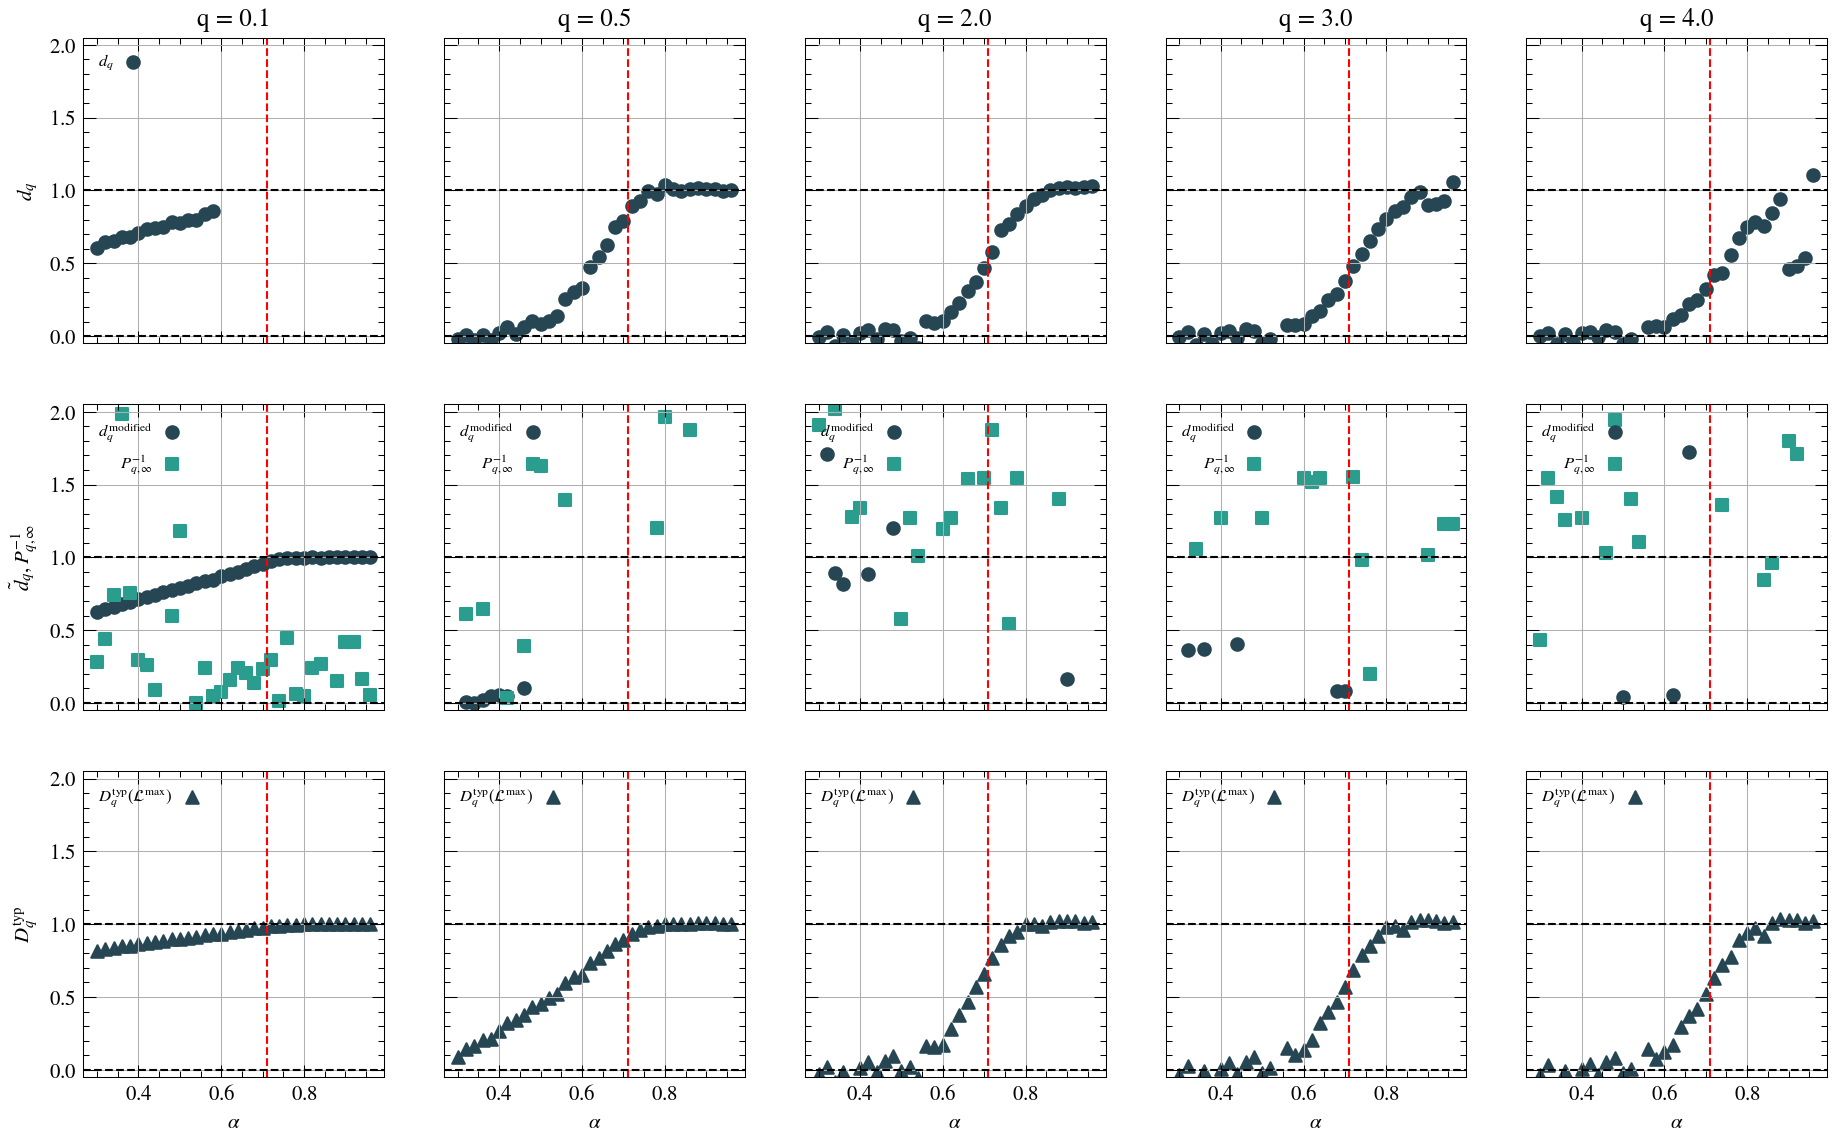

In [ ]:
fig, ax     = Plotter.get_subplots(nrows=3, ncols=len(qs), figsize=(3 * len(qs), 3 * 3), dpi = 150, sharex=True, sharey=True)
len_qs      = len(qs)
for i, q in enumerate(qs):
    logger.info(f"Plotting for q={q}", lvl=1, color='blue')
    ax[i].set_title(f"q = {q:.1f}", fontsize=12)
    ax[-i - 1].set_xlabel(r"$\alpha$")
    ax[0 * len_qs].set_ylabel(r"$d_q$")
    ax[1 * len_qs].set_ylabel(r"$\tilde {d}_q, P^{-1}_{q, \infty}$")
    ax[2 * len_qs].set_ylabel(r"$D^{\rm typ}_q$")
    
    # plot the average fractal dimension
    frac_av_q       = np.array(frac_av[q]) 
    logger.info(f"Fractal dimension (average) for q={q}: {frac_av_q}", lvl=2, color='blue')
    frac_av_mod_q   = np.abs(np.array(frac_av_mod[q]) / (q - 1.0))
    logger.info(f"Fractal dimension (average mod) for q={q}: {frac_av_mod_q}", lvl=2, color='green')
    frac_av_mod_c_q = np.abs(frac_av_mod_c[q])
    logger.info(f"Fractal dimension (average mod c) for q={q}: {frac_av_mod_c_q}", lvl=2, color='white')
    frac_typ_q      = np.array(frac_typ[q])
    logger.info(f"Fractal dimension (typical) for q={q}: {frac_typ_q}", lvl=2, color='red')
    ax[0 * len_qs + i].scatter(alphas_done, frac_av_q, marker='o', label=r'$d_{q}$' if i == 0 else None)
    ax[1 * len_qs + i].scatter(alphas_done, frac_av_mod_q, marker='o', label=r'$d_q^{\rm modified }$')
    ax[1 * len_qs + i].scatter(alphas_done, frac_av_mod_c_q, marker='s', label=r'$P^{-1}_{q, \infty}$')
    ax[2 * len_qs + i].scatter(alphas_done, frac_typ_q, marker='^', label=r'$D_{q}^{\rm typ}(\mathcal{L}^{\max})$')

    Plotter.set_legend(ax[0 * len_qs + i], loc='upper left', fontsize=8, ncol=1)
    Plotter.set_legend(ax[1 * len_qs + i], loc='upper left', fontsize=8, ncol=1)
    Plotter.set_legend(ax[2 * len_qs + i], loc='upper left', fontsize=8, ncol=1)
    
for a in ax:
    Plotter.set_tickparams(a)
    a.set_ylim([-.05, 2.05])
    a.axvline(0.71, color='red', linestyle='--', label=r"$\alpha_c \approx 0.71$")
    a.axhline(0.0, color='black', linestyle='--')
    a.axhline(1.0, color='black', linestyle='--')
    a.grid(True)


##### Scan with $\alpha$

In [ ]:
from QES.general_python.physics.__operators__ import Operators

directory_lips_random_models    = Directories(r"/media/klimak/ObiOne/FADING_RAN_MODELS/FINAL/DATA/ETH_MAT_TIME_EVO")
directory_lips_random_models2   = Directories(r"/media/klimak/ObiOne/FADING_RAN_MODELS/FINAL/DATA/ETH_MAT_TIME_EVO/ETH_MAT_TIME_EVO")
directory_bem2_random_models    = Directories(r"/media/klimak/ObiOne/ObiTwoBackup/BEM_2_NEW/DATA/ETH_MAT_TIME_EVO")
directory_bem2_random_models2   = Directories(r"/media/klimak/ObiOne/ObiTwoBackup/BEM_2_NEW/DATA/ETH_MAT_TIME_EVO/ETH_MAT_TIME_EVO")

def get_ldos_full(directories   : list,
                dir_save_parsed : Directories,
                dir_save_raw_new: Directories,
                alphas          : list, 
                ns              : int, 
                ops             : list, # list of operators to read
                n               : int   = None, 
                statetype       : str   = 'ME', 
                model           : str   = 'UM',
                verbose         : bool  = False,
                rm_and_mv_2_new : bool  = True,
                ):   
    
    # are you sure you want to remove?
    if rm_and_mv_2_new:
        # check for user input 'enter' to continue
        out = input(f"Are you sure you want to remove the directories as {dir_save_raw_new} is set? 'no' to cancel...")
        if out.lower() == 'no':
            logger.error("Operation cancelled by user.", 1, color='red')
            return
        else:
            dir_save_raw_new.mkdir(parents=True, exist_ok=True) # create the directory if it does not exist
            
    dir_save_parsed.mkdir(parents=True, exist_ok=True)          # create the directory if it does not exist
    
    # go through the operators
    # for if_op, f_op in enumerate(ops):
    # f_op_n                  = Operators.resolve_operator(f_op, ns)  # resolve the operator name to a string
    qs                      = [0.5, 1.0, 2.0, 3.0, 4.0] # divide by 2, as we have the LDOS, which is already squared
    data_out                = {}
    data_out.update({ f'{a:.3f}/ipr/mean/{q:.1f}' : [] for q in qs for a in alphas })
    data_out.update({ f'{a:.3f}/ipr/raw/{q:.1f}' : 0.0 for q in qs for a in alphas })
    data_out.update({ f'{a:.3f}/part_ent/mean/{q:.1f}' : [] for q in qs for a in alphas })
    data_out.update({ f'{a:.3f}/part_ent/raw/{q:.1f}' : 0.0 for q in qs for a in alphas })
    # estimation!
    Nh                      = 2**ns
    
    # go through alphas
    alphas_done             = []
    for ia, alpha in enumerate(alphas):
        logger.title(f"Reading alpha = {alpha} - ns = {ns}", 50, "-", 3)
        dirs_in                 = [d.format(ns, alpha) for d in directories]
        model                   = UltrametricModel(ns = ns, n = n, alphas = alpha)
        modelstr                = str(model)
        if rm_and_mv_2_new:
            dir_save_raw_new_in = dir_save_raw_new / modelstr
            dir_save_raw_new_in.mkdir(parents=True, exist_ok=True)
            
        #######################################
        logger.info(f"Reading from: {dirs_in} : {modelstr}", 4, verbose = verbose, color='green')
        
        filelist        = [x for d in dirs_in for x in d.list_files(filters = [lambda x: str(x).endswith('h5')])]
        logger.info(f"Found {len(filelist)} files...", 4, verbose = verbose, color='green')
        filelist_ldos   = [str(x) for x in filelist if "ldos_" in str(x)]
        filelist_diag   = [str(x) for x in filelist if "diag_" in str(x)]
        filelist_evo    = [str(x) for x in filelist if "evo_" in str(x)]
        filelist_stat   = [str(x) for x in filelist if "stat_" in str(x) or "energy_" in str(x)]
        logger.info(f"Found {len(filelist_ldos)} LDOS files, {len(filelist_diag)} diagonal files, {len(filelist_evo)} time evolution files, and {len(filelist_stat)} statistics files...", 4, verbose = verbose, color='green')
        
        if len(filelist) > 0:
            try:
                ldos        = HDF5Manager.load_data_from_multiple_files(file_paths=filelist_ldos, dataset_keys=[statetype])
                ldos        = [x[statetype] for x in ldos]
                ldos        = [y for x in ldos for y in x if y.shape[0] > 0]    # flatten and remove empty arrays
                ldos        = np.array(ldos, dtype=float)
                #! check if it's all zeros on axis 1, if so, skip this row
                ldos        = ldos[~np.all(ldos < 1e-14, axis=1)]
                #! check if is smaller that -1e5 - threshold for save
                ldos        = ldos[~np.all(ldos < -1e5, axis=1)]
                #! create iprs
                iprs                    = { q: statistical.inverse_participation_ratio(ldos.T, q = q, square=False) for q in qs }
                #! create participation entropies
                participation_entropies = { q: entropy.participation_entropy(ldos.T, q = q / 2, square=False) for q in qs }

                for q in qs:
                    data_out[f'{alpha:.3f}/ipr/mean/{q:.1f}'].append(np.mean(iprs[q]))
                    data_out[f'{alpha:.3f}/ipr/raw/{q:.1f}']        = iprs[q]
                    data_out[f'{alpha:.3f}/part_ent/mean/{q:.1f}'].append(np.mean(participation_entropies[q]))
                    data_out[f'{alpha:.3f}/part_ent/raw/{q:.1f}']   = participation_entropies[q]

                #! create the file in the new directory and remove the old ones
                if rm_and_mv_2_new:
                    random_num  = np.random.randint(1, 99999)
                    file_name   = f"ldos_R={random_num}.h5"
                    file_path   = dir_save_raw_new_in / file_name
                    HDF5Manager.save_data_to_file(directory=dir_save_raw_new_in, filename=file_name, data_to_save={statetype: ldos}, overwrite=True)
                    logger.info(f"Saved LDOS data to {file_path}", 4, color='green')
                    # remove the old files
                    for file in filelist_ldos:
                        
                        #! do not remove the new directory
                        if dir_save_raw_new_in in file:
                            continue
                        
                        try:
                            os.remove(file)
                            logger.info(f"Removed file {file}", 5, color='blue')
                        except Exception as e:
                            logger.error(f"Could not remove file {file}: {e}", 5, color='red')

            except Exception as e:
                logger.error(f"Error reading LDOS data for alpha {alpha}: {e}", 1, color='red')
                continue
        alphas_done.append(alpha)
    
    # remove unused alphas
    data_out            = {k: v for k, v in data_out.items() if any(f'{a:.3f}' in k for a in alphas_done)}
    data_out['alphas']  = alphas_done
    # save the data to the directory
    if len(data_out) > 0:
        file_name = f"ldos_data_ns={ns}_n={n}_{statetype}.h5"
        file_path = dir_save_parsed / file_name
        HDF5Manager.save_data_to_file(directory=dir_save_parsed, filename=file_name, data_to_save=data_out, overwrite=True)
    return data_out

Nss     = [8, 9, 10, 11, 12, 13, 14, 15, 16]
Nss     = [8, 9]
g0      = 1.0
alphas  = np.arange(0.5, 0.98, 0.01)
# alphas  = [0.760]
# ops     = ['entanglement_entropy']
ops     = ['Sz/0']
state   = 'ME'
MODEL   = 'um'
n       = 1  # number of grains

#! get the directories
directory_data          = Directories(r",ultrametric,Ns={}," + f"N={n}" + ",g0=1.00,alpha={:.3f}")
directory_data_lips     = directory_lips_random_models  / directory_data
directory_data_bem      = directory_bem2_random_models  / directory_data
directory_data_lips2    = directory_lips_random_models2 / directory_data
directory_data_bem2     = directory_bem2_random_models2 / directory_data
dir_save_raw_new        = Directories('/media/klimak/ObiOne/FADING_RAN_MODELS/reparsed_all_together/time_evo', 'um')
directory_data          = [directory_data_lips, directory_data_bem, directory_data_lips2, directory_data_bem2, dir_save_raw_new]
directory_s             = Directories(os.curdir, 'saved', 'log', 'processed')

for op in ops:
    for Ns in Nss:  
        logger.title(f"Ns = {Ns}, operator = {op}", 50, "-", 0)
        opin    = Operators.resolve_operator(op, Ns)
        get_ldos_full(
            directories         = directory_data,
            dir_save_parsed     = directory_s,
            dir_save_raw_new    = dir_save_raw_new,
            alphas              = alphas,
            ns                  = Ns,
            ops                 = [opin],
            n                   = n,  # number of grains
            statetype           = state,
            model               = MODEL,
            verbose             = True,
            rm_and_mv_2_new     = False
        )

27_06_2025_10-28_31 [INFO] -------------Ns = 8, operator = Sz/0-------------
27_06_2025_10-28_31 [INFO] 			->-----------Reading alpha = 0.5 - ns = 8-----------
27_06_2025_10-28_31 [INFO] 				->Reading from: [Directories(PosixPath('/media/klimak/ObiOne/FADING_RAN_MODELS/FINAL/DATA/ETH_MAT_TIME_EVO/,ultrametric,Ns=8,N=1,g0=1.00,alpha=0.500')), Directories(PosixPath('/media/klimak/ObiOne/ObiTwoBackup/BEM_2_NEW/DATA/ETH_MAT_TIME_EVO/,ultrametric,Ns=8,N=1,g0=1.00,alpha=0.500')), Directories(PosixPath('/media/klimak/ObiOne/FADING_RAN_MODELS/FINAL/DATA/ETH_MAT_TIME_EVO/ETH_MAT_TIME_EVO/,ultrametric,Ns=8,N=1,g0=1.00,alpha=0.500')), Directories(PosixPath('/media/klimak/ObiOne/ObiTwoBackup/BEM_2_NEW/DATA/ETH_MAT_TIME_EVO/ETH_MAT_TIME_EVO/,ultrametric,Ns=8,N=1,g0=1.00,alpha=0.500')), Directories(PosixPath('/media/klimak/ObiOne/FADING_RAN_MODELS/reparsed_all_together/time_evo/um'))] : Ultrametric(ns=8,N=1,J=1.0,g=1.0,a=0.500)
27_06_2025_10-28_31 [INFO] 				->Found 0 files...
27_06_2025_10-28_31 [I

#### Get all 

In [71]:
import matplotlib.pyplot as plt
colors_map, norm, cmap = Plotter.get_colormap(np.arange(8, 15, dtype = int), 'viridis_r')

def get_results_single(directories_python   : List[Directories],
                    alpha                   : float,
                    ns                      : int,
                    n                       : int,
                    uniform                 : bool = False,
                    operator                : str  = 'Sz/0',
                    plotme                  : bool = False,):
    
    logger.info(f"alpha: {alpha:.2f}, ns: {ns}, n: {n}, uniform: {uniform}, operator: {operator}", color='red')
    
    if plotme:
        fig, ax     = Plotter.get_subplots(nrows = 1, ncols = 5, figsize = (15, 3), dpi = 150)
        fig.suptitle(f"$\\alpha={alpha:.2f}, L={ns-n}$")
    else:
        fig, ax     = None, [None] * 5
    
    color_ns        = colors_map(ns)
    mean_lvl        = mls_df.loc[f'{alpha:.2f}', ns] if f"{alpha:.2f}" in mls_df.index else mls_df.iloc[0].loc[ns]
    mean_lvl_lim    = mean_lvl / 50
    logger.info(f"mean level: {mean_lvl}", lvl = 2)

    # --------------------------------------------------------
    #! energy
    data = read_energy(directories  = directories_python,
                    alpha           = alpha,
                    ns              = ns,
                    n               = n)
    if data is None:
        return None, None, None    
    
    (data_energy, mean_lvl_spacing, bandwidth_data, gr) = data['energy']
    data_ldos                                           = data['ldos']
    iprs, participation_entropies                       = data['iprs'], data['participation_entropies']
    if plotme:
        Plotter.vline(ax[0], mean_lvl_spacing, label=r'$\Delta$', ls='--', color = 'black')
        Plotter.vline(ax[2], mean_lvl_spacing, label=r'$\Delta$', ls='--', color = 'black')
        Plotter.vline(ax[3], mean_lvl_spacing, label=r'$\Delta$', ls='--', color = 'black')
    logger.info(f"mean level spacing true: {mean_lvl_spacing}", lvl = 2)
    
    # --------------------------------------------------------
    #! spectral functions
    data = read_histogram(directories   = directories_python,
                        alpha           = alpha,
                        ns              = ns,
                        n               = n,
                        operator        = operator)
    ((data_hist_bins, data_hist_av), (data_hist_bins, data_hist_typ), data_hist_count)  = data['histogram']
    (oms, smooth, cdf, g)                                                               = data['cdf']
    (omst, smootht, cdft, gt)                                                           = data['cdf_typ']
    
    if plotme:
        ax[0].stairs(data_hist_av[1:], data_hist_bins, label=r'$O^2(\omega)$', ls=next(linestylesCycle), color = 'red')
        Plotter.vline(ax[0], g, label=r'$\Gamma$', ls='--', color = 'green', lw = 1.5)
        Plotter.plot(ax[3], oms, smooth, label=r'$O^2(\omega)$', ls='--', color = 'red')
    
        #! twinax
        ax3_twiny = ax[3].twinx()
        ax3_twiny.set_ylim(0, 1)
        Plotter.plot(ax3_twiny, oms, cdf, label=r'$cdf[O^2(\omega)]$', ls=next(linestylesCycle), color = 'blue')
        # Plotter.set_ax_params(ax3_twiny, xlabel=r'$\omega$', ylabel=r'$cdf[O^2(\omega)]$', xscale='log', yscale='linear', xlim=(mean_lvl_lim, None), ylim=(0, 1))
        
        # ax[3].plot(omegas2, y_smoothed2, label=r'typ[$O^2(\omega)$]', ls=next(linestylesCycle), color = 'purple')
        ax[2].axvline(g, label=r'$\Gamma$', ls='--', color = 'green')
        ax[3].axvline(g, label=r'$\Gamma$', ls='--', color = 'green')

    # --------------------------------------------------------
    #! time evolution
    data = read_time_evolution_uniform(directories      = directories_python,
                                        alpha           = alpha,
                                        ns              = ns,
                                        n               = n,
                                        operator        = operator)
    (data_evo_time, data_evo_av, data_evo_av_rm, data_evo_d_av) = data['evolution']
    (distr_bins, distr)                                         = data['distribution'][0]
    (distr_bins_rm, distr_rm)                                   = data['distribution'][1]
    (mu, mu2, mu3, mu4)                                         = data['moments'][0]
    moms                                                        = np.array([mu, mu2, mu3, mu4], dtype=float)
    (mu_rm, mu2_rm, mu3_rm, mu4_rm)                             = data['moments'][1]
    moms_rm                                                     = np.array([mu_rm, mu2_rm, mu3_rm, mu4_rm], dtype=float)
    (data_evo_fft_om, data_evo_fft, data_evo_fft_n)             = data['fft']

    if plotme:
        Plotter.plot(ax[1], data_evo_time, np.mean(data_evo_av, axis = 0) + 1, label=r'$\tilde{C}(t) + 1$', color = color_ns)
        Plotter.plot(ax[1], data_evo_time, np.mean(data_evo_av_rm, axis = 0) + 1, label=r'$\tilde{C}(t)_{\rm MA} + 1$', color = 'black')
        Plotter.plot(ax[4], distr_bins, distr, label=r'$P(\tilde{C}(t))$', ls=next(linestylesCycle), color = color_ns)
        Plotter.plot(ax[0], data_evo_fft_om, data_evo_fft, label=r'$\tilde{S}(\omega)$', ls='-', color = color_ns)
        Plotter.plot(ax[2], data_evo_fft_om, data_evo_fft, label=r'$\tilde{S}(\omega)$', ls='-', color = color_ns)

    # --------------------------------------------------------
    #! k-functions
    k_functions, k_counts   = extract_k_functions(data_ldos, data_energy, data_hist_bins)
    if plotme:
        ax[0].stairs(k_functions, data_hist_bins, label=r'$K(\omega)$', linestyle=":", color = 'black')
    
    # --------------------------------------------------------
    #! multiply k and histograms together
    k_times_hist, k_times_hist_norm = extract_k_times_o2(k_functions, data_hist_av, data_hist_bins)
    if plotme:
        ax[2].stairs(k_times_hist, data_hist_bins, label=r'$K(\omega) \cdot O^2(\omega)$', ls='--', color = 'black', lw = 1.5)

    #! -------------------------------------------------------
    if plotme:
        Plotter.set_ax_params(ax[0], xlabel=r'$\omega$', ylabel=r'$\tilde{S}(\omega)$', xscale='log', yscale='log', xlim=(mean_lvl_lim, 1e1))
        Plotter.set_ax_params(ax[1], xlabel=r'$t$', ylabel=r'$(C(t)-C_{\rm diag}) + 1$', xscale='log', yscale='log')
        Plotter.set_ax_params(ax[2], xlabel=r'$\omega$', ylabel=r'$K(\omega) O^2(\omega)$', xscale='log', yscale='log', xlim=(mean_lvl_lim, 1e1))
        Plotter.set_ax_params(ax[3], xlabel=r'$\omega$', ylabel=r'$cdf[O^2(\omega)]$', xscale='log', yscale='log', xlim=(mean_lvl_lim, 1e1))
        Plotter.set_ax_params(ax[4], xlabel=r'$\tilde{C}(t)$', ylabel=r'$P(\tilde{C}(t))$', xscale='linear', yscale='log')
        for axis in ax:
            Plotter.set_legend(axis, framealpha=0.5, fontsize=8, frameon=True)
            Plotter.set_tickparams(axis)
            if axis != ax[1] and axis != ax[4]:
                axis.set_xlim(mean_lvl_lim, 1e1)
            axis.grid()
            
        fig.tight_layout()
    
    data_out = {
        'n_realizations'    : len(data_energy),
        'k/base'            : k_functions,
        # multiplication of k-functions and histogram
        'kO2/av'            : k_times_hist,                                     # k-functions multiplied by the spectral function - unnormalized          
        'kO2/integral'      : k_times_hist_norm,                                # normalization factor for the k-functions multiplied by the spectral function
        'kO2/omegas'        : data_hist_bins,                                   # bins for the k-functions multiplied by the spectral function              
        # only the spectral function
        'O2/av/raw'         : data_hist_av,                                     # average spectral function - unnormalized
        'O2/av/smooth'      : smooth,                                           # smoothed spectral function for the average spectral function                  
        'O2/av/cdf'         : cdf,                                              # cumulative distribution function for the average spectral function                            
        'O2/av/gamma'       : g,                                                # Thouless energy for the average spectral function                     
        'O2/typ/raw'        : data_hist_typ,                                    # typical spectral function - unnormalized     
        'O2/typ/smooth'     : smootht,                                          # smoothed spectral function for the typical spectral function                 
        'O2/typ/cdf'        : cdft,                                             # cumulative distribution function for the typical spectral function                               
        'O2/typ/gamma'      : gt,                                               # Thouless energy for the typical spectral function
        'O2/count'          : data_hist_count,                                  # counts for the histogram                          
        'O2/omegas'         : oms,                                              # bins for the spectral function 
        # time evolution
        'evo/time'          : data_evo_time,                                    # time axis
        'evo/de'            : data_evo_d_av,                                    # diagonal ensemble                     
        'evo/av'            : np.mean(data_evo_av, axis = 0),                   # time evolution average - probably not needed
        'evo/moving_av_rm'  : np.mean(data_evo_av_rm, axis = 0),                # time evolution average with moving average - probably not needed
        'evo/dist/de/bins'  : distr_bins,                                       # bins for the distribution of the diagonal ensemble             
        'evo/dist/de/vals'  : distr,                                            # values for the distribution of the diagonal ensemble                     
        'evo/dist/mv/bins'  : distr_bins_rm,                                    # bins for the distribution of the moving average                    
        'evo/dist/mv/vals'  : distr_rm,                                         # values for the distribution of the moving average       
        'evo/dist/de/mom'  : moms,                                              # moments of the diagonal ensemble (E, E^2, E^3, E^4)
        'evo/dist/mv/mom'  : moms_rm,                                           # moments of the moving average (E, E^2, E^3, E^4)
        # fft
        'fft/s'             : data_evo_fft,                                     # FFT of the time evolution average - normalized and averaged
        'fft/integral'      : data_evo_fft_n,                                   # normalization factor for the FFT of the time evolution average                        
        'fft/om'            : data_evo_fft_om,                                  # frequencies for the FFT of the time evolution average    
        # statistical properties 
        'stat/gamma_th'     : g,                                                # is the Thouless energy
        'stat/gamma_th_typ' : gt,                                               # is the Thouless energy for the typical spectral function
        'stat/mean_lvl'     : mean_lvl_spacing,                                 # mean level spacing
        'stat/bw'           : bandwidth_data,                                   # bandwidth of the energy distribution        
        'stat/var'          : np.mean(np.var(data_energy, axis=1), axis=0),
        'stat/gap_ratio'    : gr,                                               # gap ratio for the energy distribution                                            
        # iprs of the initial state
        'ipr/mean/0.5'      : np.mean(iprs[0.5], axis = 0),                     # iprs for the initial state
        'ipr/mean/1.0'      : np.mean(iprs[1.0], axis = 0),                     # iprs for the initial state
        'ipr/mean/2.0'      : np.mean(iprs[2.0], axis = 0),                     # iprs for the initial state
        'ipr/mean/3.0'      : np.mean(iprs[3.0], axis = 0),                     # iprs for the initial state
        'ipr/mean/4.0'      : np.mean(iprs[4.0], axis = 0),                     # iprs for the initial state
        'ipr/raw/0.5'       : iprs[0.5],                                        # iprs for the initial state
        'ipr/raw/1.0'       : iprs[1.0],                                        # iprs for the initial state
        'ipr/raw/2.0'       : iprs[2.0],                                        # iprs for the initial state
        'ipr/raw/3.0'       : iprs[3.0],                                        # iprs for the initial state
        'ipr/raw/4.0'       : iprs[4.0],                                        # iprs for the initial state
        # participation entropies of the initial state
        'part_ent/0.5'      : np.mean(participation_entropies[0.5]),
        'part_ent/1.0'      : np.mean(participation_entropies[1.0]),
        'part_ent/2.0'      : np.mean(participation_entropies[2.0]),
        'part_ent/3.0'      : np.mean(participation_entropies[3.0]),
        'part_ent/4.0'      : np.mean(participation_entropies[4.0]),
        'part_ent/raw/0.5'  : participation_entropies[0.5],
        'part_ent/raw/1.0'  : participation_entropies[1.0],
        'part_ent/raw/2.0'  : participation_entropies[2.0],
        'part_ent/raw/3.0'  : participation_entropies[3.0],
        'part_ent/raw/4.0'  : participation_entropies[4.0],
    }
    return data_out, fig, ax

### Scrap

In [72]:
alphas          = np.arange(0.68, 0.95, 0.06)
alphas          = np.arange(0.3, 0.95, 0.02)
# alphas          = [0.3, 0.74, 0.92]
sites           = np.arange(7, 17, dtype=int)
# sites           = np.arange(7, 12, dtype=int)
n               = 1
uniform         = True
plotme          = len(sites) * len(alphas) < 10
plotme          = False

directory_s     = Directories(os.curdir, 'saved', 'uniform', 'processed')
directory_s.mkdir(parents=True, exist_ok=True)
for alpha in alphas:
    for ns in sites:
        directories_python      = [ Directories(os.path.abspath(data_dir), 'uniform' if uniform else 'log'),
                                    Directories(os.path.abspath('data_final'), 'uniform' if uniform else 'log')]
        try:
            y, fig, ax              = get_results_single(directories_python =   directories_python,
                                                        alpha               =   alpha,
                                                        ns                  =   ns,
                                                        n                   =   n,
                                                        uniform             =   True,
                                                        plotme              =   plotme)
            if y is None:
                continue
        except Exception as e:
            logger.error(f"Error processing alpha {alpha:.2f}, ns {ns}, n {n}: {e}", color='red')
            continue
        HDF5Manager.save_data_to_file(directory=directory_s, filename = f'alpha_{alpha:.2f}_ns_{ns}_n_{n}.h5', data_to_save=y)
        if plotme:
            plt.savefig(directory_s / f'alpha_{alpha:.2f}_ns_{ns}_n_{n}.png', dpi=150)
            plt.savefig(directory_s / f'alpha_{alpha:.2f}_ns_{ns}_n_{n}.pdf', dpi=150)

01_07_2025_19-19_22 [INFO] alpha: 0.30, ns: 7, n: 1, uniform: True, operator: Sz/0
01_07_2025_19-19_22 [INFO] 		->mean level: 0.08378684
01_07_2025_19-19_22 [INFO] alpha: 0.30, ns: 8, n: 1, uniform: True, operator: Sz/0
01_07_2025_19-19_22 [INFO] 		->mean level: 0.041310933
01_07_2025_19-19_22 [INFO] 		->mean level spacing true: 0.020820946733790095
01_07_2025_19-19_22 [INFO] 		->data_evo_time shape: (100000,)
01_07_2025_19-19_22 [INFO] 			->data_evo_samples: [400, 400] for Ultrametric(ns=8,N=1,J=1.0,g=1.0,a=0.300)
01_07_2025_19-19_22 [INFO] 				->reshaped to: (800, 100000)
01_07_2025_19-19_38 [INFO] 		->time delta: 5.71775580930667, time num: 100000, shape: (49999,)
01_07_2025_19-19_38 [INFO] 			->data_evo_fft shape: (49999,)
01_07_2025_19-19_38 [INFO] alpha: 0.30, ns: 9, n: 1, uniform: True, operator: Sz/0
01_07_2025_19-19_38 [INFO] 		->mean level: 0.021381415
01_07_2025_19-19_38 [INFO] 		->mean level spacing true: 0.011163045012901728
01_07_2025_19-19_38 [INFO] 		->data_evo_time sha

08_07_2025_18-10_41 [ERROR] File does not exist: /home/klimak/Codes/QuantumEigenSolver/Python/projects/2025/um_evolotion/saved/uniform/processed/alpha_0.70_ns_7_n_1.h5
08_07_2025_18-10_41 [ERROR] Invalid file: /home/klimak/Codes/QuantumEigenSolver/Python/projects/2025/um_evolotion/saved/uniform/processed/alpha_0.70_ns_7_n_1.h5
08_07_2025_18-10_41 [ERROR] File does not exist: /home/klimak/Codes/QuantumEigenSolver/Python/projects/2025/um_evolotion/saved/uniform/processed/alpha_0.70_ns_14_n_1.h5
08_07_2025_18-10_41 [ERROR] Invalid file: /home/klimak/Codes/QuantumEigenSolver/Python/projects/2025/um_evolotion/saved/uniform/processed/alpha_0.70_ns_14_n_1.h5
08_07_2025_18-10_41 [ERROR] File does not exist: /home/klimak/Codes/QuantumEigenSolver/Python/projects/2025/um_evolotion/saved/uniform/processed/alpha_0.70_ns_16_n_1.h5
08_07_2025_18-10_41 [ERROR] Invalid file: /home/klimak/Codes/QuantumEigenSolver/Python/projects/2025/um_evolotion/saved/uniform/processed/alpha_0.70_ns_16_n_1.h5
Alpha: 0.

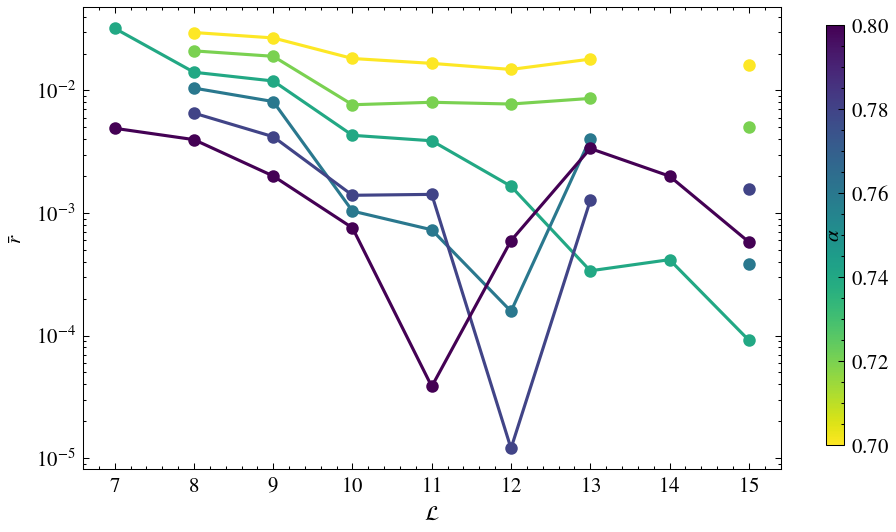

In [6]:
path_saved  = Directories("/home/klimak/Codes/QuantumEigenSolver/Python/projects/2025/um_evolotion/saved/uniform/processed")
alphas      = np.arange(0.7, 0.8, 0.02)
sites       = np.arange(7, 17, dtype=int)
fig, ax     = Plotter.get_subplots(nrows=1, ncols=1, figsize=(6, 4), dpi=150)
for alpha in alphas:
    gap_ratios = []
    nss_in     = []
    colormap, color, cmap = Plotter.get_colormap(alphas, 'viridis_r')
    for ns in sites:
        try:
            # data       = HDF5Manager.load_data_from_file(directory=path_saved, filename=f'alpha_{alpha:.2f}_ns_{ns}_n_1.h5')
            data       = HDF5Manager.load_file_data(file_path = str(path_saved / f'alpha_{alpha:.2f}_ns_{ns}_n_1.h5'))

            gap_ratio  = data.get('/stat/gap_ratio', None)
            gap_ratios.append(gap_ratio)
            nss_in.append(ns)
        except Exception as e:
            print(f"Error loading data for alpha={alpha:.2f}, ns={ns}: {e}")
    print(f"Alpha: {alpha:.2f}, Nss: {nss_in}, Gap Ratios: {gap_ratios}")
    if gap_ratios:
        # gap_ratios = np.array([(np.abs(2 * np.log(2) - 1 - gr) if gr is not None else np.nan) for gr in gap_ratios])
        gap_ratios = np.array([(np.abs(0.53 - gr) if gr is not None else np.nan) for gr in gap_ratios])
        # gap_ratios = np.array([g if g is not None else np.nan for g in gap_ratios])
        ax[0].plot(nss_in, gap_ratios, label=f'α={alpha:.2f}', marker='o', color=colormap(alpha), linestyle='-', linewidth=1.5, markersize=5)
ax[0].set_xscale('linear')
ax[0].set_xlabel(r'$\mathcal{L}$')
ax[0].set_ylabel(r'$\bar r$')
ax[0].set_yscale('log')
Plotter.add_colorbar_pos(fig, color, mapable=alphas, pos=(0.95, 0.15, 0.02, 0.7), ylabel=r'$\alpha$')